# FNST
## Fast Neural Style Transfer

Checking the Fast Neural Style Transfer from [ONNX Zoo Pretrained Model](https://github.com/onnx/models/tree/master/vision/style_transfer/fast_neural_style).

Requirements:

- OnnxRuntime
- OpenCV 2
- MatplotLib
- Numpy
- Nice source picture located in `$PROJECT_ROOT/source.extension`


In [0]:
%%capture

try:
  import onnxruntime as ort
except ImportError:
  !pip install onnxruntime
  import onnxruntime as ort

import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Download pretrained models

In [0]:
%%capture

models_dir = 'models'
styles = ['mosaic', 'candy', 'rain-princess', 'udnie', 'pointilism']
pretrained_url = 'https://github.com/onnx/models/raw/master/vision/style_transfer/fast_neural_style/model/{}-9.onnx'

if not os.path.isdir(models_dir):
  os.mkdir(models_dir)
  for s in styles:
    !wget {pretrained_url.format(s)} -P {models_dir}

## Load and preprocess source image

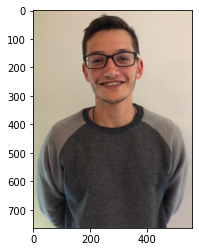

In [3]:
# Load
source_path = glob.glob('source.*')[0]
im = cv2.imread(source_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Save original size
original_size = im.shape[1], im.shape[0]

# Resize
x = cv2.resize(im, (224, 224))

# Preprocess image
x = x.astype(np.float32)
x = np.transpose(x, [2, 0, 1])
x = np.expand_dims(x, axis=0)

plt.imshow(im)

## Source through all models

In [0]:
import onnxruntime as ort

results = []
results.append(('original', im))

for s in styles:

  # create session
  model_path = os.path.join(models_dir, f'{s}-9.onnx')
  sess = ort.InferenceSession(model_path)
  output_name = sess.get_outputs()[0].name
  input_name = sess.get_inputs()[0].name

  # pass
  result = sess.run([output_name], {input_name: x})[0][0] 

  # postprocess
  result = np.clip(result, 0, 255)
  result = result.transpose(1,2,0).astype("uint8")

  # resize to fit original
  target = cv2.resize(result, original_size)

  # save
  results.append((s, target))

## Show results

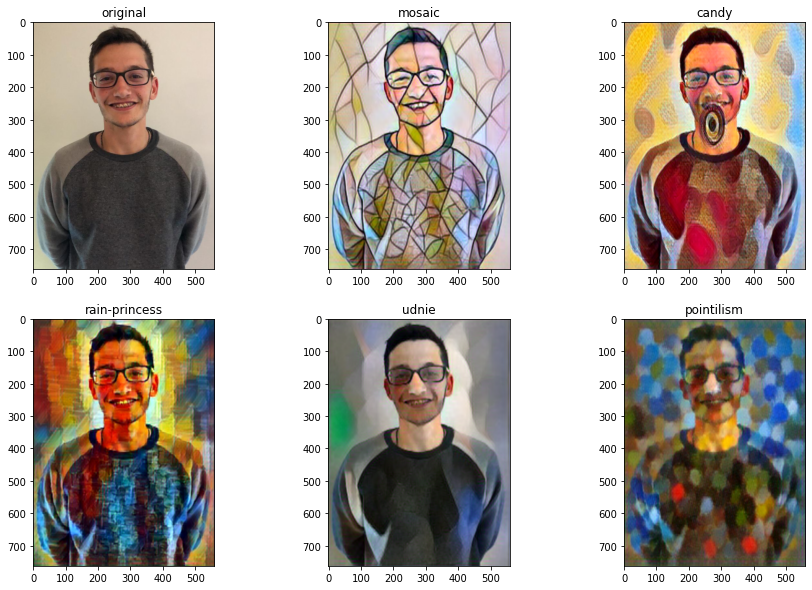

In [5]:
f, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()

for i, (s, r) in enumerate(results):
  ax[i].set_title(s)
  ax[i].imshow(r)

## Save results

In [0]:
os.mkdir('results')
for s, r in results:
  cv2.imwrite(f'results/{s}.png', r)